In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the data 
df = pd.read_csv('zoo.csv')
df=df.drop_duplicates(subset=['animal_name'], keep='first')
df_a = np.array(df)
#df.head()
# Change it to array


In [3]:
#df.set_index(["class_type", "legs"]).count(level="class_type")

In [4]:
# This is the color tag array
Y_a=np.array(df['class_type'])

In [6]:
# remove the marking features
features = list(df.columns)
features.remove('class_type')
features.remove('animal_name')
#print(features)

In [7]:
# X is the data set that needs to be visualized
# Y suggests the markers' colors
X = df[features].values.astype(np.float32)
Y = df.class_type
#print(X.shape)
#print(Y.shape)

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
X_std = StandardScaler().fit_transform(X)

In [9]:
X_std_pca = pca.fit_transform(X_std)[:,:2]

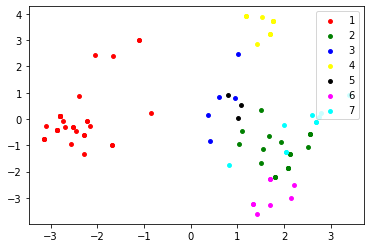

In [10]:
# make the color dictionary
cdict = {1:'red',2:'green',3:'blue',4:'yellow',5:'black',6:'magenta',7:'cyan'}

fig, ax = plt.subplots()
for g in np.unique(Y_a):
    idx = np.where(Y_a == g)
    ax.scatter(X_std_pca[idx,0], X_std_pca[idx,1], c = cdict[g], label = g,s=15)
ax.legend(loc="upper right")
plt.savefig("./Fig/pca.png",dpi=300,bbox_inches='tight')
plt.show()

In [41]:
def mds(D,d):
    length= len(D)
    S= np.zeros([length, length])
    D2=D ** 2
    ss = 1.0 /(length ** 2) * D2.sum()
    for i in range(length):
        for j in range(length):
            S[i, j] = -0.5 * (D[i, j] ** 2 - 1.0 / length * D2[:,j].sum() - 1.0 / length * D2[i,:].sum() + ss)
 
    e,v=np.linalg.eigh(S)
    e_sort=np.argsort(-e)
    e=e[e_sort]
    v=v[:,e_sort]
    ek=np.diag(e[0:d])
    vk=v[:,0:d]
    X=np.dot(np.sqrt(ek),vk.T).T
    return X

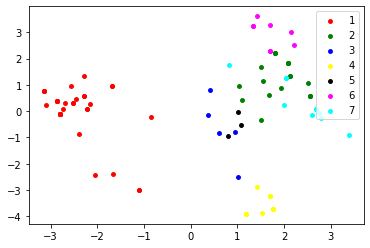

In [12]:
from scipy.spatial.distance import pdist, squareform
X_std_D = pdist(X_std, 'euclidean')
X_std_D = squareform(X_std_D) 
X_std_mds=mds(X_std_D,2)

fig, ax = plt.subplots()
for g in np.unique(Y_a):
    idx = np.where(Y_a == g)
    ax.scatter(X_std_mds[idx,0], X_std_mds[idx,1], c = cdict[g], label = g,s=15)
ax.legend(loc="upper right")
plt.savefig("./Fig/mds.png",dpi=300,bbox_inches='tight')
plt.show()

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf=ExtraTreesClassifier(n_estimators=50)
clf.fit(X_std, Y_a)
temp=clf.feature_importances_
feature_importances=np.sqrt((temp)/np.std(temp))

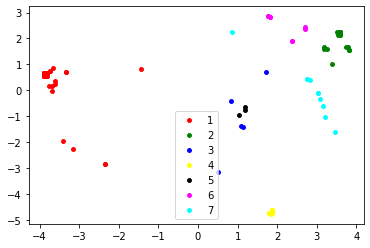

In [14]:
weighted_X=np.zeros([X_std.shape[0],X_std.shape[1]])
for i in range(0,weighted_X.shape[0]):
    weighted_X[i,:]=feature_importances
    
weighted_X=X_std*weighted_X
weighted_X_D = pdist(weighted_X, 'euclidean')
weighted_X_D = squareform(weighted_X_D) 
weighted_X_mds=mds(weighted_X_D,2)

fig, ax = plt.subplots()
for g in np.unique(Y_a):
    idx = np.where(Y_a == g)
    ax.scatter(weighted_X_mds[idx,0], weighted_X_mds[idx,1], c = cdict[g], label = g,s=15)
ax.legend(loc="best")
plt.savefig("./Fig/weighted_mds.png",dpi=300,bbox_inches='tight')
plt.show()

In [15]:
# Floyd-Warshall algorithm to compute the shortest path distance
def floyd(D):
    n= D.shape[0]
    for k in range(n):
        for i in range(n):
            for j in range(n):
                D[i][j] = min(D[i][j],D[i][k]+D[k][j])
    return D

In [16]:
def get_k_nearest_mat(Y, k):
    D = pdist(Y, 'euclidean')     
    D = squareform(D)         
    inf = float('inf') 
    n = D.shape[0]
    # The distance between points are initialized to inf
    k_D = np.ones([n, n])*inf
    # Each point is connected to its k nearest points,
    for i in range(n):
        topk = np.argpartition(D[i], k)[:k + 1]
        k_D[i][topk] = D[i][topk]
    return k_D

In [17]:
def isomap(Y, k, d):
    k_D = get_k_nearest_mat(Y, k)
    D = floyd(k_D)
    X = mds(D, d)
    return X

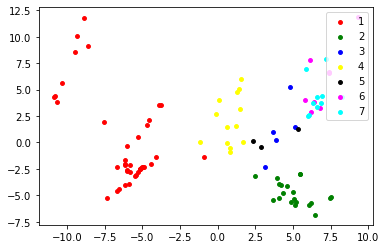

In [35]:
# Small k will leads to inf in the distance matrix,
# After some tries, the minimum value of k is 18.
X_std_iso=isomap(X_std, 18, 2)

fig, ax = plt.subplots()
for g in np.unique(Y_a):
    ix = np.where(Y_a == g)
    ax.scatter(X_std_iso[ix,0], X_std_iso[ix,1], c = cdict[g], label = g,s=15)
ax.legend(loc="upper right")
plt.savefig("./Fig/isomap18.png",dpi=300,bbox_inches='tight')
plt.show()

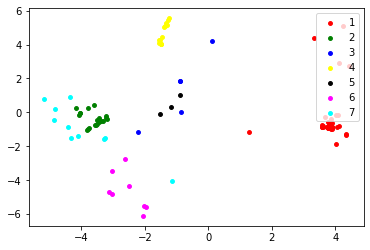

In [42]:
# The input matrix is the weighted version
# Small k will leads to inf in the distance matrix,
# After some tries, the minimum value of k is 37.
Weighted_iso=isomap(weighted_X, 90, 2)

fig, ax = plt.subplots()
for g in np.unique(Y_a):
    ix = np.where(Y_a == g)
    ax.scatter(Weighted_iso[ix,0], Weighted_iso[ix,1], c = cdict[g], label = g,s=15)
ax.legend(loc="upper right")
plt.savefig("./Fig/weighted_isomap90.png",dpi=300,bbox_inches='tight')
plt.show()

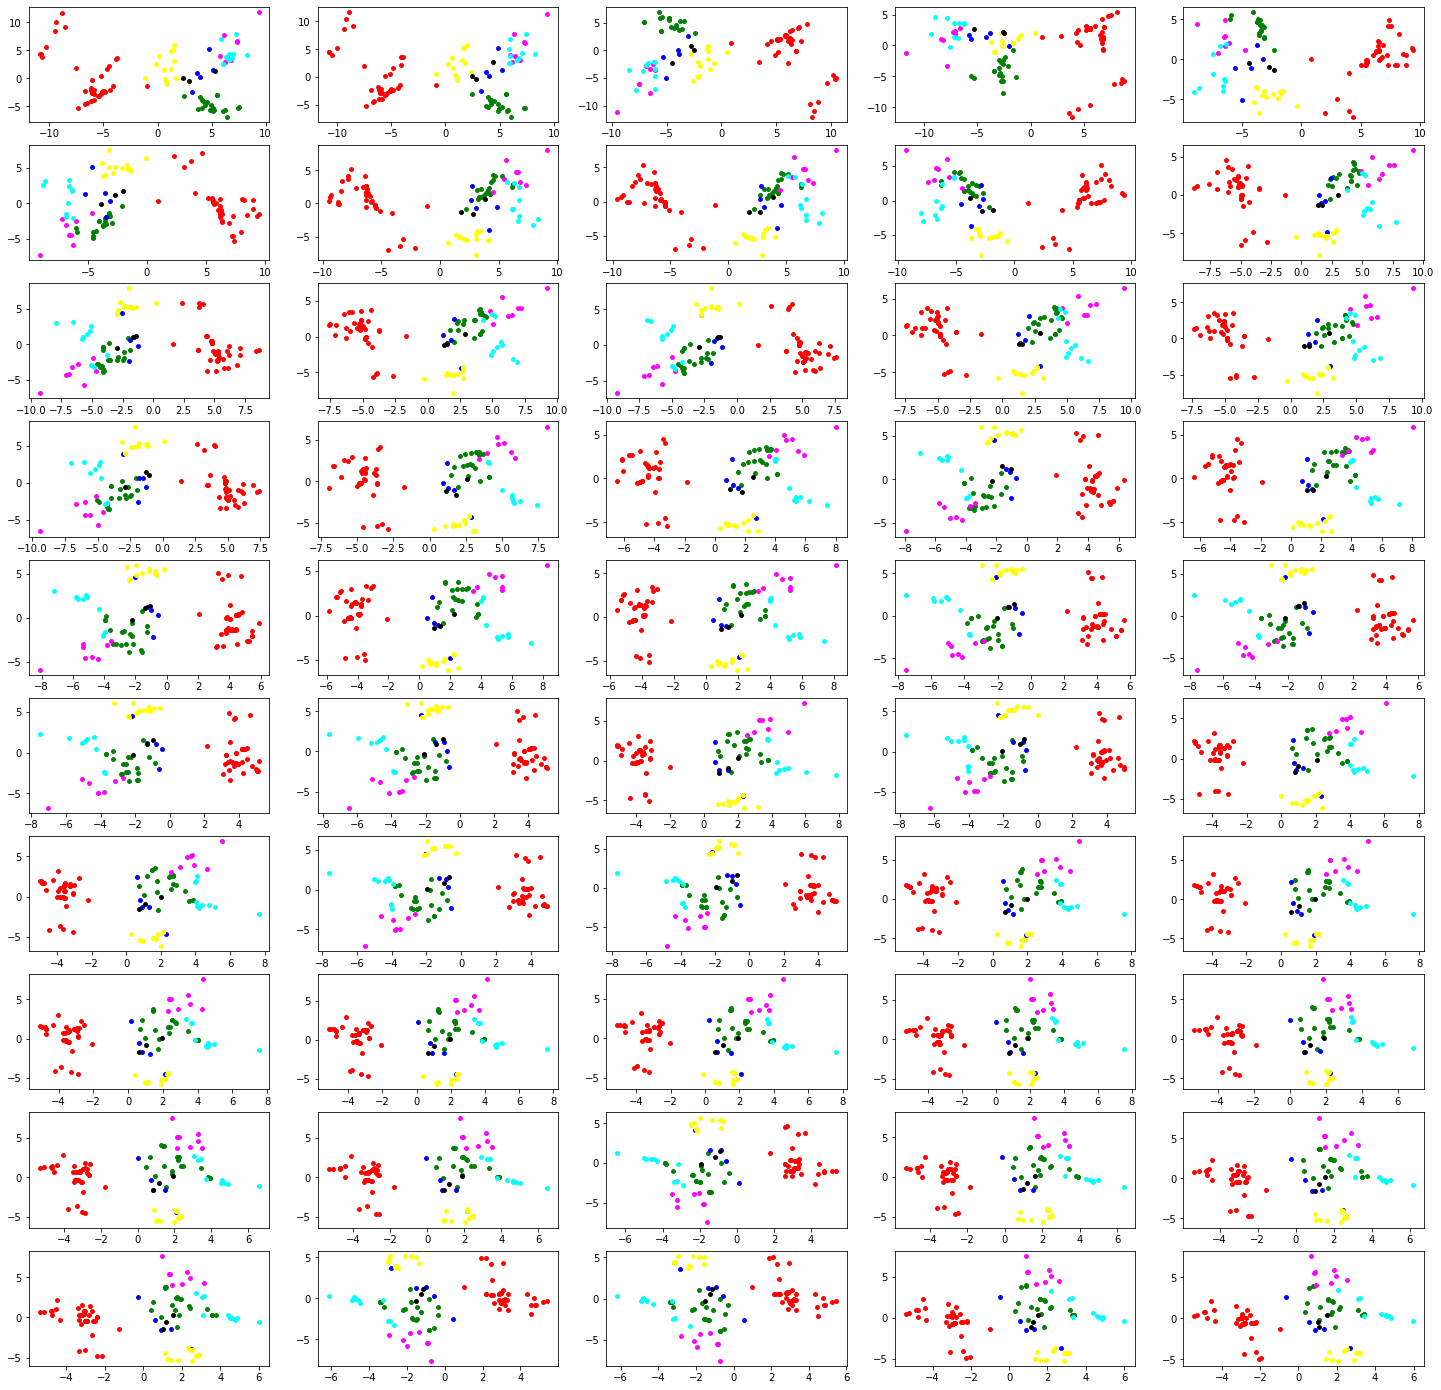

In [24]:
# To try with the k from 18-67
fig, axes = plt.subplots(10,5, figsize=(25, 25))
ax = axes.flatten()
for j in range(0,50):
    iso=isomap(X_std, j+18, 2)
    for g in np.unique(Y_a):
        ix = np.where(Y_a == g)
        ax[j].scatter(iso[ix,0], iso[ix,1], c = cdict[g], label = g,s=15)
    #ax[j].legend(loc="upper right")
plt.savefig("./Fig/isomap18_67.png",dpi=300,bbox_inches='tight')

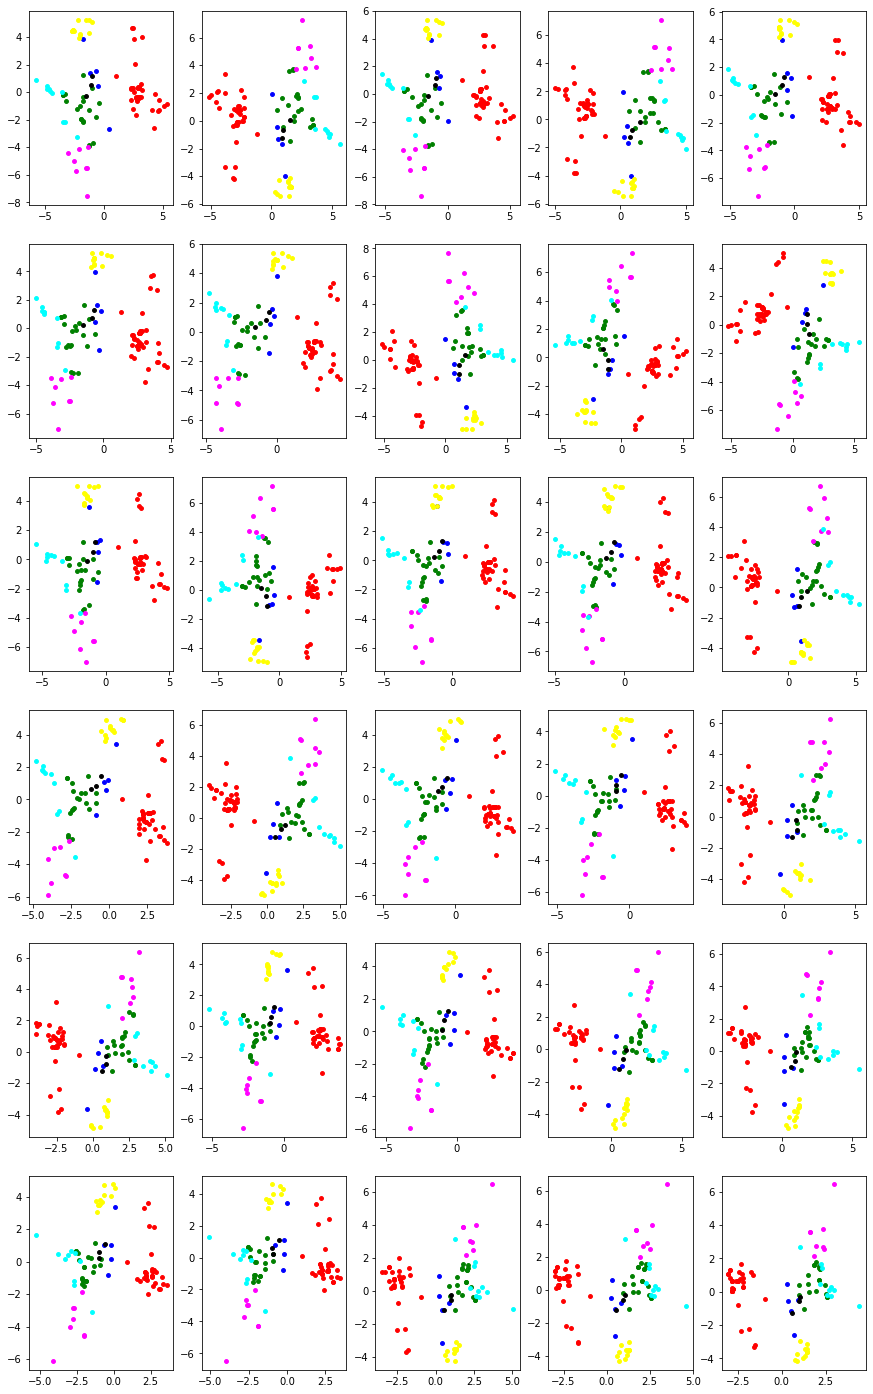

In [23]:
# To try with the k from 68-97
fig, axes = plt.subplots(6,5, figsize=(15, 25))
ax = axes.flatten()
for j in range(50,80):
    iso=isomap(X_std, j+18, 2)
    for g in np.unique(Y_a):
        ix = np.where(Y_a == g)
        ax[j-50].scatter(iso[ix,0], iso[ix,1], c = cdict[g], label = g,s=15)
    #ax[j-50].legend(loc="upper right")
plt.savefig("./Fig/isomap68_97.png",dpi=300,bbox_inches='tight')

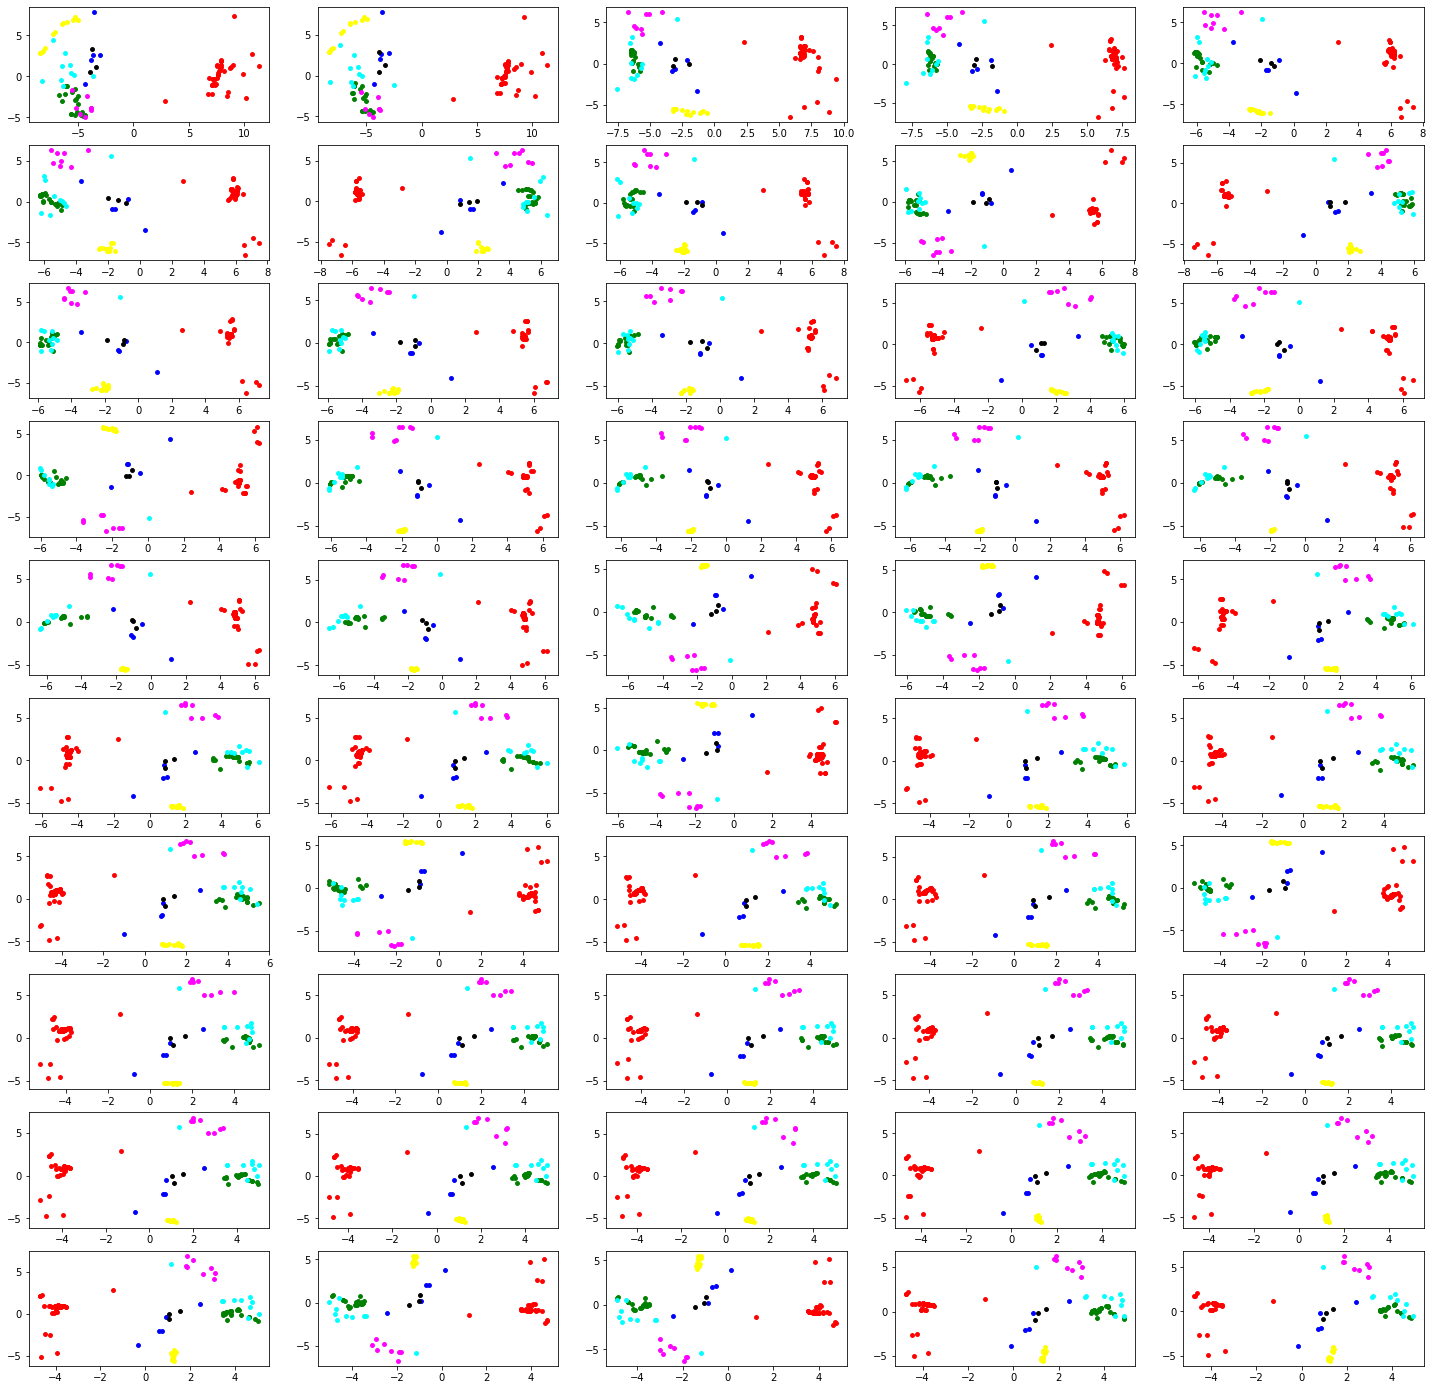

In [22]:
# To try with the k from 37-86
fig, axes = plt.subplots(10,5, figsize=(25, 25))
ax = axes.flatten()
for j in range(0,50):
    iso=isomap(weighted_X, j+37, 2)
    for g in np.unique(Y_a):
        ix = np.where(Y_a == g)
        ax[j].scatter(iso[ix,0], iso[ix,1], c = cdict[g], label = g,s=15)
    #ax[j].legend(loc="upper right")
plt.savefig("./Fig/weighted_isomap37_66.png",dpi=300,bbox_inches='tight')

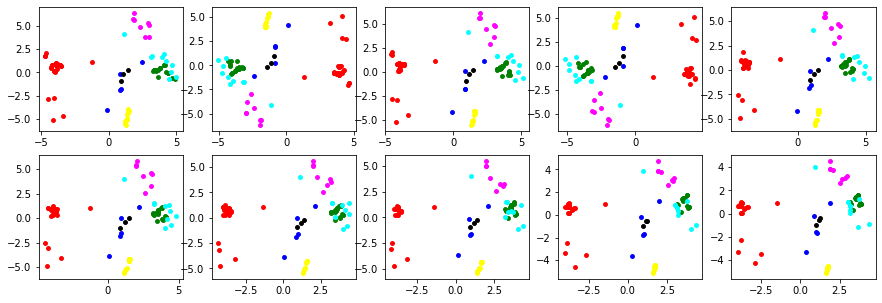

In [30]:
# To try with the k from 37-86
fig, axes = plt.subplots(2,5, figsize=(15, 5))
ax = axes.flatten()
for j in range(50,60):
    iso=isomap(weighted_X, j+37, 2)
    for g in np.unique(Y_a):
        ix = np.where(Y_a == g)
        ax[j-50].scatter(iso[ix,0], iso[ix,1], c = cdict[g], label = g,s=15)
    #ax[j].legend(loc="upper right")
plt.savefig("./Fig/weighted_isomap87_96.png",dpi=300,bbox_inches='tight')

In [37]:
from sklearn import manifold

mds=manifold.MDS(n_components=2)
X_std_mds=mds.fit_transform(X_std)

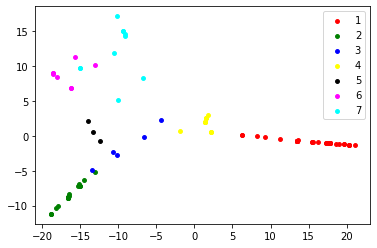

In [43]:
iso=manifold.Isomap(n_components=2,n_neighbors=4)
X_std_iso_sk=iso.fit_transform(X_std)
fig, ax = plt.subplots()
for g in np.unique(Y_a):
    ix = np.where(Y_a == g)
    ax.scatter(X_std_iso_sk[ix,0], X_std_iso_sk[ix,1], c = cdict[g], label = g,s=15)
ax.legend(loc="upper right")
plt.savefig("./Fig/isomap_sk4.png",dpi=300,bbox_inches='tight')
plt.show()